In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import cv2
import os
import numpy as np
import shutil
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import math
from PIL import Image
import torch.nn as nn
import yaml
import random
from google.colab import files
import sys
import time
from torch.utils.data import random_split
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu" # 檢查是否有可用的 CUDA 設備（通常是顯卡，支援 GPU 運算），如果有，就將 device 變數設置為 "cuda"，否則設置為 "cpu"。
from __future__ import print_function
import zipfile
import os
import pdb
import torch
import h5py
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets, transforms, utils
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from torch.autograd import Variable
# from logger import Logger
import pdb
import os
import re
import numpy as np
import time


import torch
import cv2
import os
# os.chdir('/content/drive/MyDrive/Colab Notebooks/Simple_DE') # this path is the path of the current .ipynb
import numpy as np
import shutil
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import math
from PIL import Image
import torch.nn as nn
import yaml
import random
from google.colab import files
import sys
import time
from torch.utils.data import random_split
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu" # 檢查是否有可用的 CUDA 設備（通常是顯卡，支援 GPU 運算），如果有，就將 device 變數設置為 "cuda"，否則設置為 "cpu"。
from torch.optim.lr_scheduler import LambdaLR

In [3]:
def load_config(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

In [4]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Model/config/config.yml' # main
# file_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Model/config/config.yml' # free
config = load_config(file_path)

In [5]:
output_height = 64
output_width = 64
batch_size = 32

In [6]:
class TransposeDepthInput(object):
    def __call__(self, depth):
        depth = depth.transpose((2, 0, 1))
        depth = torch.from_numpy(depth)
        depth = depth.view(1, depth.shape[0], depth.shape[1], depth.shape[2])
        depth = nn.functional.interpolate(depth, size=(output_height, output_width), mode='bilinear', align_corners=False)
        # depth = torch.log(depth)
        return depth[0]

In [7]:
rgb_data_transforms = transforms.Compose([
    transforms.Resize((output_height, output_width)),    # Different for Input Image & Depth Image
    transforms.ToTensor(),
    ])

In [8]:
depth_data_transforms = transforms.Compose([
    TransposeDepthInput(),
])

In [9]:
input_for_plot_transforms = transforms.Compose([
    transforms.Resize((output_height, output_width)),    # Different for Input Image & Depth Image
    transforms.ToTensor(),
])

In [10]:
class NYUDataset(Dataset):
    def calculate_mean(self, images):
        mean_image = np.mean(images, axis=0)
        return mean_image

    def __init__(self, filename, type, rgb_transform = None, depth_transform = None):
        f = h5py.File(filename, 'r')
        if type == "training":
            self.images = f['images'][0:1400]
            self.depths = f['depths'][0:1400]
        elif type == "validation":
            self.images = f['images'][1024:1248]
            self.depths = f['depths'][1024:1248]
        elif type == "test":
            self.images = f['images'][1400:]
            self.depths = f['depths'][1400:]
        self.rgb_transform = rgb_transform
        self.depth_transform = depth_transform
        self.mean_image = self.calculate_mean(f['images'][0:1449])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        # image = (image - self.mean_image)/np.std(image)
        image = image.transpose((2, 1, 0))
        # image = (image - image.min())/(image.max() - image.min())
        # image = image * 255
        # image = image.astype('uint8')
        image = Image.fromarray(image)
        if self.rgb_transform:
            image = self.rgb_transform(image)
        depth = self.depths[idx]
        depth = np.reshape(depth, (1, depth.shape[0], depth.shape[1]))
        depth = depth.transpose((2, 1, 0))
        if self.depth_transform:
            depth = self.depth_transform(depth)
        sample = {'image': image, 'depth': depth}
        return sample

In [11]:
# path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/nyu_depth_v2_labeled.mat' # for free account
path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/nyu_depth_v2_labeled.mat' # for main account
train_loader = torch.utils.data.DataLoader(NYUDataset( path,
                                                       'training',
                                                        rgb_transform = rgb_data_transforms,
                                                        depth_transform = depth_data_transforms),
                                            batch_size = batch_size,
                                            shuffle = True, num_workers = 5)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
test_loader = torch.utils.data.DataLoader(NYUDataset( path,
                                                       'test',
                                                        rgb_transform = rgb_data_transforms,
                                                        depth_transform = depth_data_transforms),
                                            batch_size = batch_size,
                                            shuffle = False, num_workers = 5)



In [13]:
# val_loader = torch.utils.data.DataLoader(NYUDataset( path,
#                                                        'test',
#                                                         rgb_transform = rgb_data_transforms,
#                                                         depth_transform = depth_data_transforms),
#                                             batch_size = batch_size,
#                                             shuffle = False, num_workers = 5)


# # train_loader = val_loader

In [14]:
class Upsample(nn.Module): # this
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            self.conv = torch.nn.Conv2d(in_channels,  # this conv let the size unchanged
                                        in_channels,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, x):
        x = torch.nn.functional.interpolate(
            x, scale_factor=2.0, mode="nearest") # double the size
        if self.with_conv:
            x = self.conv(x)
        return x

In [15]:
class Downsample(nn.Module):
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            # no asymmetric padding in torch conv, must do it ourselves
            self.conv = torch.nn.Conv2d(in_channels,  # halves the size
                                        in_channels,
                                        kernel_size=3,
                                        stride=2,
                                        padding=0)

    def forward(self, x):
        if self.with_conv:
            pad = (0, 1, 0, 1)
            x = torch.nn.functional.pad(x, pad, mode="constant", value=0) # 此動作相當於在每個圖片的channel的右邊下面pad 0
            x = self.conv(x)
        else:
            x = torch.nn.functional.avg_pool2d(x, kernel_size=2, stride=2)
        return x

In [16]:
class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels=None, conv_shortcut=False,
                 dropout):
        super().__init__()

        self.in_channels = in_channels
        self.Lrelu = nn.ELU()
        # self.Lrelu = nonlinearity
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels
        self.use_conv_shortcut = conv_shortcut

        self.norm1 =nn.BatchNorm2d(in_channels)     # 這裡上面define的Normalize有點像是class的感覺
        self.conv1 = torch.nn.Conv2d(in_channels, # size unchanged
                                     out_channels,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)

        self.norm2 = nn.BatchNorm2d(out_channels)
        self.dropout = torch.nn.Dropout(dropout) # param為機率
        self.conv2 = torch.nn.Conv2d(out_channels, # size unchanged
                                     out_channels,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)
        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                self.conv_shortcut = torch.nn.Conv2d(in_channels,   # size unchanged
                                                     out_channels,
                                                     kernel_size=3,
                                                     stride=1,
                                                     padding=1)
            else:
                self.nin_shortcut = torch.nn.Conv2d(in_channels,    # size unchanged
                                                    out_channels,
                                                    kernel_size=1,
                                                    stride=1,
                                                    padding=0)


    def forward(self, x):
        h = x
        h = self.norm1(h)    # normalize

        h = self.Lrelu(h)  # sigmoid
        h = self.conv1(h)    # channel become out_channel


        h = self.norm2(h)
        h = self.Lrelu(h)
        h = self.dropout(h)
        h = self.conv2(h)

        if self.in_channels != self.out_channels:  # 如果inchannel和outchannel不同需要把輸入值channel也調整成一樣，用上conv2D，若inchannel和outchannel一樣就直接加
            if self.use_conv_shortcut:
                x = self.conv_shortcut(x)
            else:
                x = self.nin_shortcut(x)

        return x+h

In [17]:
# modified
class AttnBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels

        self.norm = nn.BatchNorm2d(in_channels)
        self.q = torch.nn.Conv2d(in_channels, # in_cha == out_cha and the kernel size = 1, and size unchanged
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.k = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.v = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.proj_out = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=1,
                                        stride=1,
                                        padding=0)
        self.norm2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        h_ = x
        h_ = self.norm(h_)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        # compute attention
        b, c, h, w = q.shape # (batch, channel, height, width)
        q = q.reshape(b, c, h*w)
        q = q.permute(0, 2, 1)   # b,hw,c.  # 此兩變換(reshape + permute)詳細情形如下格，簡單來說最外圈還是每一個data(一張照片)，
                                # 往內一圈則是把該資料的所有channel(rgb)的同個位置放在一起
        k = k.reshape(b, c, h*w)  # b,c,hw # 單一此變換則是外圈是data，向內一圈則是該data一個channel內所有的值
        w_ = torch.bmm(q, k)     # b,hw,hw    w[b,i,j]=sum_c q[b,i,c]k[b,c,j]
        # 注意這邊是q * k，是把不同channels的同個位置變成vector然後內積，這樣跟cnn最大的差別是cnn只會在同一個區塊做相關性，attention卻在channels中的每個位置會相互做相關性
        w_ = w_ * (int(c)**(-0.5)) # 為何不是 * (int(h * w) ** (-0.5))?
        w_ = torch.nn.functional.softmax(w_, dim=2)

        # attend to values
        v = v.reshape(b, c, h*w)
        w_ = w_.permute(0, 2, 1)   # b,hw,hw (first hw of k, second of q)
        # b, c,hw (hw of q) h_[b,c,j] = sum_i v[b,c,i] w_[b,i,j]
        h_ = torch.bmm(v, w_)
        h_ = h_.reshape(b, c, h, w)

        h_ = self.norm2(self.proj_out(h_))


        return x+h_

In [18]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ELU()
        # self.Lrelu = nn.ELU()
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [19]:
class Model(nn.Module):
    def __init__(self, config, want_print):
        super().__init__()
        self.config = config
        self.print = want_print
        ch, out_ch, ch_mult = config['model']['ch'], config['model']['out_ch'], tuple(config['model']['ch_mult'])
        # ch = 128, out_ch = 3
        num_res_blocks = config['model']['num_res_blocks']
        # num_res_blocks = 2
        attn_resolutions = config['model']['attn_resolutions']
        attn_resolutions = [32, ]
        # attn_resolution = [16, ]
        dropout = config['model']['dropout']
        # dropout = 0.0
        in_channels = config['model']['in_channels']
        # in_channels = 3
        resolution = config['data']['image_size']
        resolution = 64
        # resolution = 256
        resamp_with_conv = config['model']['resamp_with_conv']
        # resamp_with_conv = True



        if config['model']['type'] == 'bayesian':
            self.logvar = nn.Parameter(torch.zeros(num_timesteps))

        self.ch = ch
        ch_mult = (1, 2, 2)
        # ch_mult = (1, 2)

        self.num_resolutions = len(ch_mult)
        # num_resolutions = 4
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels




# nonlinear

        curr_res = resolution
        in_ch_mult = (1,)+ch_mult
        # in_ch_mult = (1, 1, 1, 2, 2)

        self.conv_down1 = ConvBlock(3, 16)
        self.conv_down2 = ConvBlock(16, 32)
        self.conv_down3 = ConvBlock(32, 64)
        self.conv_down4 = ConvBlock(64, 128)

        self.down = nn.ModuleList()
        block_in = None


        # self.conv_in = torch.nn.Conv2d(3,
        #                                self.ch,
        #                                kernel_size=3,
        #                                stride=1,
        #                                padding=1)
        for i_level in range(self.num_resolutions):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_in = ch*in_ch_mult[i_level]
            block_out = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks):

                block.append(ResnetBlock(in_channels=block_in,
                                         out_channels=block_out,

                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    print(curr_res)
                    attn.append(AttnBlock(block_in))
            down = nn.Module()
            down.block = block
            down.attn = attn
            if i_level != self.num_resolutions-1:
                down.downsample = Downsample(block_in, resamp_with_conv)
                curr_res = curr_res // 2
            self.down.append(down)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,

                                       dropout=dropout)
        self.mid.attn_1 = AttnBlock(block_in)
        self.mid.block_2 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,

                                       dropout=dropout)

        # upsampling
        self.up = nn.ModuleList()
        for i_level in reversed(range(self.num_resolutions)):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_out = ch*ch_mult[i_level]
            skip_in = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks+1):
                if i_block == self.num_res_blocks:
                    skip_in = ch*in_ch_mult[i_level] # 最後一個block時inchannel數可能變少
                block.append(ResnetBlock(in_channels=block_in+skip_in,
                                         out_channels=block_out,

                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(AttnBlock(block_in))
            up = nn.Module()
            up.block = block
            up.attn = attn
            if i_level != 0:
                up.upsample = Upsample(block_in, resamp_with_conv)
                curr_res = curr_res * 2
            self.up.insert(0, up)  # prepend to get consistent order, (0, up)代表在ModuleList()的0位置插入up這個Module

        # end
        self.norm_out = nn.BatchNorm2d(block_in)

        self.Lrelu = nn.ELU()

        self.conv_up1 = ConvBlock(128, 64)
        self.conv_up2 = ConvBlock(64, 32)
        self.conv_up3 = ConvBlock(32, 16)
        self.conv_up4 = ConvBlock(16, 3)
        self.conv_up5 = ConvBlock(3, 1)
    def forward(self, image):



        # downsampling down 裡面有好幾個元素，每個元素包含block(resblock), attn, downsample，其中attn只有幾個元素會有，downsample除了最後一個元素以外都有
        # 整個流程就是把x送進conv2D 然後送進down裡面經過resblock和部份attn downsample(conv2D)
        # hs = [self.conv_in(image)]
        h = image
        if self.print:
            print("original {}".format(h.shape))
        h = self.conv_down1(h)
        if self.print:
            print("conv_down1 {}".format(h.shape))
        h = self.conv_down2(h)
        if self.print:
            print("conv_down2 {}".format(h.shape))
        h = self.conv_down3(h)
        if self.print:
            print("conv_down3 {}".format(h.shape))
        h = self.conv_down4(h)
        if self.print:
            print("conv_down4 {}".format(h.shape))
        hs = [h]
        if self.print:
            print(hs[-1].shape)



        for i_level in range(self.num_resolutions):
            for i_block in range(self.num_res_blocks):

                h = self.down[i_level].block[i_block](hs[-1]) # h 如果可以是attn就是attn 不然就是res, note that h是把值喂進去模塊後的值，要把hs的最後跟time embedded送進去
                if self.print:
                    print("res {}".format(h.shape))


                if len(self.down[i_level].attn) > 0:
                    h = self.down[i_level].attn[i_block](h)
                    if self.print:
                        print("this is attn {}".format(h.shape))

                hs.append(h)
            if i_level != self.num_resolutions-1:
                h_temp = self.down[i_level].downsample(hs[-1])
                if self.print:
                    print("downsample {}".format(h_temp.shape))
                hs.append(h_temp)
        # return hs

        # middle
        h = hs[-1]

        h = self.mid.block_1(h)
        if self.print:
            print("mid res {}".format(h.shape))
        h = self.mid.attn_1(h)
        if self.print:
            print("mid attn {}".format(h.shape))
        h = self.mid.block_2(h)
        if self.print:
            print("mid res {}".format(h.shape))


        # upsampling
        for i_level in reversed(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks+1):

                h_cat = torch.cat([h, hs.pop()], dim=1)
                if self.print:
                    print("this is cat {}".format(h_cat.shape))
                h = self.up[i_level].block[i_block](h_cat) # u-net的cat down
                if self.print:
                    print("res {}".format(h.shape))
                if len(self.up[i_level].attn) > 0:
                    h = self.up[i_level].attn[i_block](h)
                    if self.print:
                        print("this is attn {}".format(h.shape))

            if i_level != 0:
                h = self.up[i_level].upsample(h)
                if self.print:
                    print("this is upsample {}".format(h.shape))


        # end



        h = self.norm_out(h)



        h = self.Lrelu(h)

        h = self.conv_up1(h)
        if self.print:
            print("conv_up1 {}".format(h.shape))
        h = self.conv_up2(h)
        if self.print:
            print("conv_up2 {}".format(h.shape))
        h = self.conv_up3(h)
        if self.print:
            print("conv_up3 {}".format(h.shape))
        h = self.conv_up4(h)
        if self.print:
            print("conv_up4 {}".format(h.shape))
        h = self.conv_up5(h)
        if self.print:
            print("conv_up5 {}".format(h.shape))

        return h


In [20]:
weight_path = "/content/drive/MyDrive/Colab Notebooks/Unet_Depth_Estimation/Checkpoint2/weight/weight465.pth"
model = Model(config, False)
model.to(device)
checkpoint = torch.load(weight_path, map_location = torch.device(device))
model.load_state_dict(checkpoint['model_state_dict'])

32
32


<All keys matched successfully>

In [21]:
def plot_grid(fig, plot_input, output, actual_output, row_no):
    grid = ImageGrid(fig, 141, nrows_ncols=(row_no, 4), axes_pad=0.05, label_mode="1")
    for i in range(row_no):
        for j in range(3):
            if(j == 0):
                grid[i*4+j].imshow(np.transpose(plot_input[i].cpu(), (1, 2, 0)), interpolation="nearest")
            if(j == 1):
                grid[i*4+j].imshow(np.transpose(output[i][0].detach().cpu().numpy(), (0, 1)), interpolation="nearest")
            if(j == 2):
                grid[i*4+j].imshow(np.transpose(actual_output[i][0].detach().cpu().numpy(), (0, 1)), interpolation="nearest")

In [31]:
count = 0
for  data in enumerate(train_loader):
    count = count + 1

    rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)
    # plot_input, actual_output = torch.tensor(plot_data['image'], requires_grad = False), torch.tensor(plot_data['depth'], requires_grad = False)
    plot_input = rgb.to(torch.float32)

    actual_output = depth.to(torch.float32)
    # break
    print('evaluating batch:' + str(count))
    output = model(rgb)
    depth_dim = list(depth.size())
    # actual_output = depth[:,0,:,:].view(depth_dim[0], 1, output_height, output_width)
    F = plt.figure(1, (30, 60))
    F.subplots_adjust(left=0.05, right=0.95)


    plot_grid(F, plot_input, output, actual_output, depth_dim[0])
    plt.savefig("/content/drive/MyDrive/Colab Notebooks/Unet_Depth_Estimation/output2/" + "test{}.jpg".format(count))
    plt.show()

<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:1


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:2
evaluating batch:3


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:4
evaluating batch:5


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:6


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:7


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:8


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:9


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:10


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:11


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:12


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:13


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:14


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:15


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:16


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:17


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:18


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:19


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:20


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:21


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:22


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:23


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:24


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:25


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:26


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:27


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:28


<ipython-input-31-755a956e1eeb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:29


KeyboardInterrupt: 

In [22]:
count = 0
for  data in enumerate(test_loader):
    count = count + 1

    rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)
    # plot_input, actual_output = torch.tensor(plot_data['image'], requires_grad = False), torch.tensor(plot_data['depth'], requires_grad = False)
    plot_input = rgb.to(torch.float32)

    actual_output = depth.to(torch.float32)
    # break
    print('evaluating batch:' + str(count))
    output = model(rgb)
    depth_dim = list(depth.size())
    # actual_output = depth[:,0,:,:].view(depth_dim[0], 1, output_height, output_width)
    F = plt.figure(1, (30, 60))
    F.subplots_adjust(left=0.05, right=0.95)

    plot_grid(F, plot_input, output, actual_output, depth_dim[0])
    plt.savefig("/content/drive/MyDrive/Colab Notebooks/Unet_Depth_Estimation/output4/" + "test{}.jpg".format(count))
    plt.show()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-22-4dfbcae1ef77>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:1


<ipython-input-22-4dfbcae1ef77>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb, depth = torch.tensor(data[1]['image'], requires_grad = False).to(device), torch.tensor(data[1]['depth'], requires_grad = False).to(device)


evaluating batch:2


In [29]:
data[1].keys()

dict_keys(['image', 'depth'])

In [ ]:
for input_image in test_loader:
    image = input_image['image']
    actual = input_image['depth']
    output = model(image.to(torch.float32).to(device))
    break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


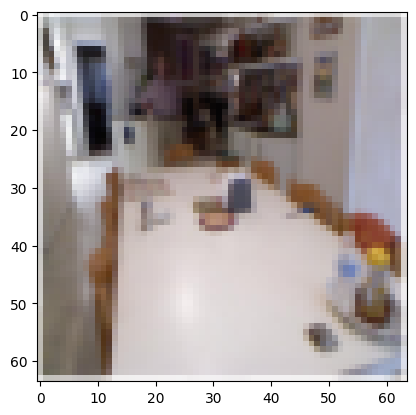

In [ ]:
i = 15

image = image.detach().cpu()

image_show = np.transpose(image[i].numpy(), (1, 2, 0))
plt.imshow(image_show, interpolation="nearest")
plt.show()

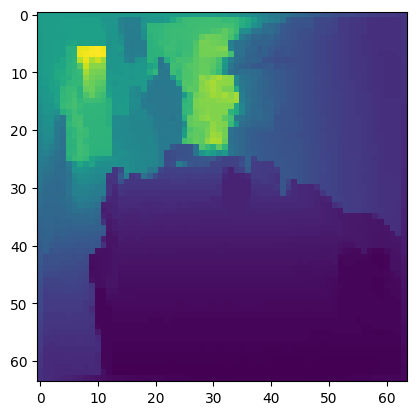

In [ ]:
actual = actual.detach().cpu()
actual_show = np.transpose(actual[i][0].numpy(), (0, 1))
plt.imshow(actual_show, interpolation="nearest")
plt.show()

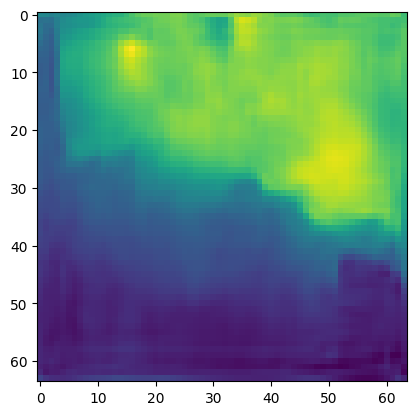

In [ ]:
output = output.detach().cpu()
output_show = np.transpose(output[i][0].numpy(), (0, 1))
plt.imshow(output_show, interpolation="nearest")
plt.show()

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
for batch in train_loader:
    image = batch['image'].to(device)
    depth = batch['depth'].to(device)
    break
print(depth.shape)

In [ ]:

# ans = model(image)

In [ ]:
# print(ans.shape)

In [ ]:
# for idx in range(len(ans)):
#     print(ans[idx].shape)


In [ ]:
def custom_loss_function(output, target):
    di = target - output
    n = (output_height * output_width)
    di2 = torch.pow(di, 2)
    fisrt_term = torch.sum(di2,(1,2,3))/n
    second_term = 0.5*torch.pow(torch.sum(di,(1,2,3)), 2)/ (n**2)
    # loss = fisrt_term - second_term
    loss = fisrt_term
    return loss.mean()

In [ ]:
# optimizer = optim.SGD(model.parameters(), lr = 0.1, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
save_frequency = 5


In [ ]:
def warmup_scheduler(epoch):
    if epoch < 10:
        return (epoch / 10)
    else:
        return 1

In [ ]:
scheduler = LambdaLR(optimizer, lr_lambda = warmup_scheduler)

In [ ]:
epochs = 200
for epoch in range(1, epochs + 1):
    training_loss = train_Unet(epoch)
    print("epoch : {} | training loss : {}".format(epoch, training_loss))

    # if epoch % 1 == 0:
    #     validate_Unet(epoch, training_loss)
    # if epoch % 1 == 0:
    #     model_file = folder_name + "/model_" + str(epoch) + ".pth"
    #     torch.save(model.state_dict(), model_file)

In [ ]:
epochs = 600
start = 485
weight_path = '/content/drive/MyDrive/Colab Notebooks/Unet_Depth_Estimation/Checkpoint/weight{}.pth'.format(start)
checkpoint = torch.load(weight_path, map_location = torch.device(device))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for epoch in range(start + 1, epochs + 1):
    training_loss = train_Unet_cont(epoch)
    print("epoch : {} | training loss : {}".format(epoch, training_loss))

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')